In [1]:
import torch
import open_clip
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import numpy as np
!pip install seaborn


c:\Users\yipka\miniconda3\envs\Cenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\yipka\miniconda3\envs\Cenv\lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
import open_clip
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

model, _, preprocess = open_clip.create_model_and_transforms(
    model_name="ViT-B-16",
    pretrained="laion400m_e31"
)

tokenizer = open_clip.get_tokenizer("ViT-B-16")

model.to(device)
model.eval()

print("Loaded:", "ViT-B-16 (DataComp-1B)")
print("Device:", next(model.parameters()).device)


Loaded: ViT-B-16 (DataComp-1B)
Device: cuda:0


In [3]:
# CELL 3: CIFAR-10 classes + smart prompt ensemble (3 templates = perfect speed/accuracy)
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

test_set = CIFAR10(root='./data', train=False, download=True, transform=preprocess)
test_loader = DataLoader(test_set, batch_size=128)

cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

templates = [
    "a photo of a {}.",
    "a blurry photo of a {}.",
    "a photo of a small {}.",
    "a close-up photo of a {}.",
    "a cropped photo of a {}.",
    "a bright photo of a {}.",
    "a low-resolution photo of a {}.",
    "a clean photo of a {}.",
    "a pixelated photo of a {}.",
]

print(f"Using {len(templates)} templates.")



Files already downloaded and verified
Using 9 templates.


In [4]:
# BUILD TEXT FEATURES (correct tokenizer)
text_features = []

for classname in cifar10_classes:
    texts = [t.format(classname) for t in templates]
    tokens = tokenizer(texts).to(device)

    with torch.no_grad():
        emb = model.encode_text(tokens)
        emb = emb / emb.norm(dim=-1, keepdim=True)

    text_features.append(emb.mean(0))

text_features = torch.stack(text_features)
text_features = text_features / text_features.norm(dim=-1, keepdim=True)

In [6]:
# RUN ZERO-SHOT
all_predictions = []
all_scores = []
true_labels = np.array(test_set.targets)

with torch.no_grad():
    for images, _ in tqdm(test_loader):
        images = images.to(device)

        img_feat = model.encode_image(images)
        img_feat = img_feat / img_feat.norm(dim=-1, keepdim=True)

        sim = (100 * img_feat @ text_features.T).softmax(dim=-1)

        all_scores.append(sim.cpu())
        all_predictions.extend(sim.argmax(dim=1).cpu().numpy())

predictions = np.array(all_predictions)
full_scores = torch.cat(all_scores).numpy()


100%|██████████| 79/79 [02:11<00:00,  1.67s/it]


ZERO-SHOT CIFAR-10 – COMPLETE RESULTS
Top-1 Accuracy       : 0.9161  →  91.61%
Top-3 Accuracy       : 0.9853  →  98.53%
Top-5 Accuracy       : 0.9957  →  99.57%
Balanced Accuracy    : 0.9161
Matthews Corr Coef   : 0.9071
Macro F1-score       : 0.9162
Weighted F1-score    : 0.9162
Macro Specificity    : 0.9907

Per-class Accuracy (worst → best)
     Class  Accuracy  Specificity
      frog     0.852       0.9973
      deer     0.877       0.9904
       dog     0.877       0.9889
       cat     0.878       0.9806
automobile     0.911       0.9990
  airplane     0.916       0.9976
      bird     0.917       0.9851
      ship     0.969       0.9947
     horse     0.972       0.9872
     truck     0.992       0.9860


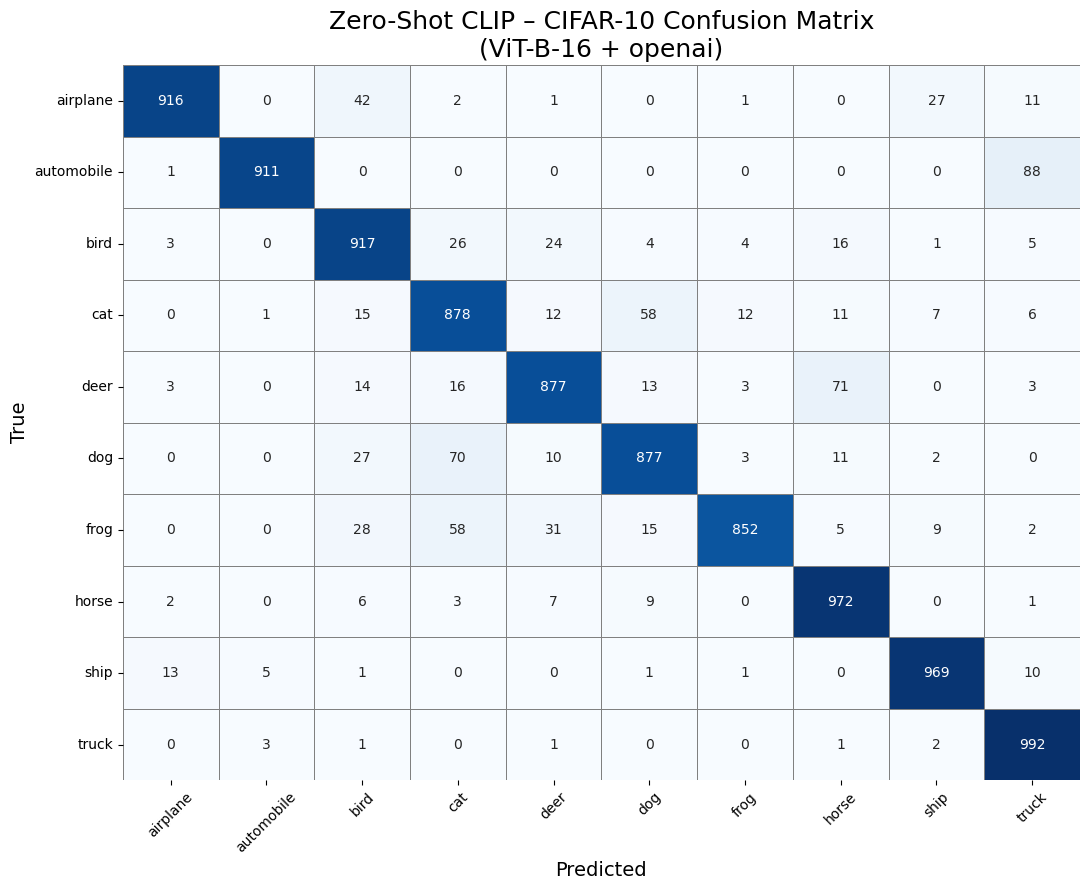

In [7]:
# CELL 6 – ALL METRICS YOU WILL EVER NEED (research-grade)
from sklearn.metrics import (
    classification_report, confusion_matrix, top_k_accuracy_score,
    balanced_accuracy_score, matthews_corrcoef, precision_recall_fscore_support
)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Convert everything to numpy once
y_true = true_labels
y_pred = predictions
y_scores = full_scores  # shape (10000, 10)

# 1. Top-k accuracies
top1 = np.mean(y_pred == y_true)
top3 = top_k_accuracy_score(y_true, y_scores, k=3)
top5 = top_k_accuracy_score(y_true, y_scores, k=5)

# 2. All classification metrics
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

balanced_acc = balanced_accuracy_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true, y_pred)

# 3. Specificity (macro-averaged)
cm = confusion_matrix(y_true, y_pred)
specificity_per_class = []
for i in range(10):
    tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
    fp = cm[:, i].sum() - cm[i, i]
    specificity_per_class.append(tn / (tn + fp) if (tn + fp) > 0 else 0)
specificity_macro = np.mean(specificity_per_class)

# 4. Per-class accuracy
per_class_acc = cm.diagonal() / cm.sum(axis=1)

# PRINT EVERYTHING BEAUTIFULLY
print("ZERO-SHOT CIFAR-10 – COMPLETE RESULTS")
print("="*60)
print(f"Top-1 Accuracy       : {top1:.4f}  →  {top1*100:05.2f}%")
print(f"Top-3 Accuracy       : {top3:.4f}  →  {top3*100:05.2f}%")
print(f"Top-5 Accuracy       : {top5:.4f}  →  {top5*100:05.2f}%")
print(f"Balanced Accuracy    : {balanced_acc:.4f}")
print(f"Matthews Corr Coef   : {mcc:.4f}")
print(f"Macro F1-score       : {f1_macro:.4f}")
print(f"Weighted F1-score    : {f1_weighted:.4f}")
print(f"Macro Specificity    : {specificity_macro:.4f}")

# Per-class table (sorted)
df_per_class = pd.DataFrame({
    'Class': cifar10_classes,
    'Accuracy': per_class_acc,
    'Specificity': specificity_per_class
}).sort_values('Accuracy')

print("\nPer-class Accuracy (worst → best)")
print(df_per_class.round(4).to_string(index=False))

# Confusion matrix
plt.figure(figsize=(11, 9))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=cifar10_classes, yticklabels=cifar10_classes,
            cbar=False, linewidths=0.5, linecolor='gray')
plt.title('Zero-Shot CLIP – CIFAR-10 Confusion Matrix\n(ViT-B-16 + openai)', fontsize=18)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()